In [ ]:
from google.colab import drive
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image, ImageDraw

from glob import glob

import zipfile
import os

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# importação dos dados

In [ ]:
dir_path = "/content/drive/MyDrive/ponderada-hayashi-sem08/"

os.listdir(dir_path)

['images.zip', 'keypoints.json', 'images']

## Unzip file

In [ ]:
zip_path = dir_path + "images.zip"

if(False): # alterar AQUI caso queira que zip seja extraído
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(dir_path)
      print("Arquivo ZIP descompactado com sucesso.")

In [ ]:
os.listdir(dir_path)

['images.zip', 'keypoints.json', 'images']

# Análise exploratória

## Leitura dos dados

In [ ]:
images_path = "/content/drive/MyDrive/ponderada-hayashi-sem08/images/*"

In [ ]:
with open(dir_path + 'keypoints.json') as j:
    data = json.load(j)

categories = pd.DataFrame(data['categories'])
annotations = pd.DataFrame(data['annotations']).merge(categories[['id', 'name']], left_on='category_id', right_on='id')

print("Dados sobre anotações:\n")
print(annotations.head())

print("Dados sobre as categorias disponíveis:\n")
print(categories['name'])

Dados sobre anotações:

   image_id                  bbox  \
0         1  [123, 115, 379, 275]   
1        11  [217, 118, 305, 263]   
2        21  [100, 212, 303, 414]   
3        22   [108, 60, 320, 160]   
4        22  [228, 138, 381, 375]   

                                           keypoints  num_keypoints  \
0  [[193, 216, 1], [160, 217, 1], [174, 261, 1], ...             20   
1  [[277, 134, 1], [255, 135, 1], [272, 148, 1], ...             20   
2  [[186, 255, 1], [133, 258, 1], [136, 290, 1], ...             20   
3  [[305, 79, 1], [282, 84, 1], [310, 109, 1], [3...             20   
4  [[270, 177, 1], [243, 166, 1], [236, 207, 1], ...             20   

   category_id  id name  
0            1   1  dog  
1            1   1  dog  
2            1   1  dog  
3            1   1  dog  
4            1   1  dog  
Dados sobre as categorias disponíveis:

0      dog
1      cat
2    sheep
3    horse
4      cow
Name: name, dtype: object


Pode-se verificar que existem 5 classes possíveis, dog, cat, sheep, horse e cow

## Quantidade de imagens

In [ ]:
count = 0

for path in glob(images_path):
  count += 1

print("Quantidade total de images:", count)

Quantidade total de images: 4608


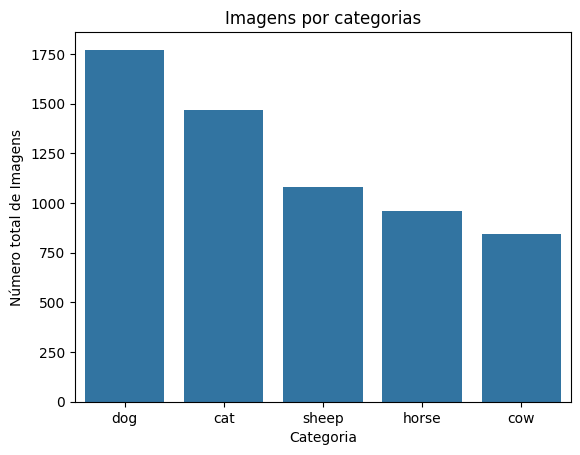

In [ ]:
# Contagem de imagens por categoria
images_per_category = annotations['name'].value_counts()

# Gráfico de contagem de imagens por categoria
plt.title('Imagens por categorias')
plt.xlabel('Categoria')
plt.ylabel('Número total de Imagens')
sns.barplot(x=images_per_category.index, y=images_per_category.values)
plt.show()

In [ ]:
# Número de imagens de bovinos (vacas)
num_cows = images_per_category.get('cow')
print(f"Número total de imagens de bovinos:", num_cows)
num_dogs = images_per_category.get('dog')
print(f"Número total de imagens de cachorros:", num_dogs)
num_cats = images_per_category.get('cat')
print(f"Número total de imagens de gatos:", num_cats)
num_sheeps = images_per_category.get('sheep')
print(f"Número total de imagens de ovelhas:", num_sheeps)
num_horses = images_per_category.get('horse')
print(f"Número total de imagens de cavalos:", num_horses)

Número total de imagens de bovinos: 842
Número total de imagens de cachorros: 1771
Número total de imagens de gatos: 1466
Número total de imagens de ovelhas: 1078
Número total de imagens de cavalos: 960


Assim conclui-se que, de 4608 imagens totais presentes no dataset, 842 são de bovinos(vacas), 1771 de cachorros, 1466 de gatos, 1078 de ovelhas e 960 de cavalos

# Filtragem dataset

In [ ]:
images_list = [{'id': int(k), 'file_name': v} for k, v in data['images'].items()]
images_df = pd.DataFrame(images_list)

print(images_df.head())

   id        file_name
0   1  2007_000063.jpg
1   2  2007_000175.jpg
2   3  2007_000332.jpg
3   4  2007_000392.jpg
4   5  2007_000464.jpg


Na análise exploratória foi possível verificar que os dados de 'annotations', quando convertidos para um dataframe, possuem uma coluna chamada 'image_id', portanto, ela será utilizada para pegarmos os id's das imagens de vaca que possuem annotations. Depois disso, na variável "cow_df" será armazenada um df somente com as imagens de vacas que possuem annotation.

In [ ]:
cow_annotations = annotations[annotations['name'] == 'cow']

cow_ids = cow_annotations['image_id']
cow_images_ids = images_df['id'].isin(cow_ids)

cow_df = images_df[cow_images_ids]

print(f"Número total de imagens de bovinos que possuem annotation: {len(cow_df)}")

Número total de imagens de bovinos que possuem annotation: 534


## Pré-processamento e processamento de keypoints

Na função a seguir ("process_image"), é feita a nomalização dos pixels da imagem para um valor entre 0 e 1, além de redimensionar a imagem para 256x256 pixels, formato padrão para uma possível leitura de um modelo de pose estimation

In [100]:
def process_image(image_path, keypoints, skeleton, resize_shape):
    image = Image.open(image_path)

    # Mostra os keypoints da imagem na própria imagem
    draw = ImageDraw.Draw(image)
    for kp in keypoints:
        x, y, value = kp
        if x > 0 and y > 0 and value > 0:
            draw.ellipse((x-2, y-2, x+2, y+2), fill=(0, 255, 0))

    for point in skeleton:
        kp1, kp2 = point
        x1, y1, value1 = keypoints[kp1]
        x2, y2, value2 = keypoints[kp2]
        if value1 > 0 and value2 > 0:
            draw.line((x1, y1, x2, y2), fill=(255, 0, 0), width=2)

    resized_image = image.resize(resize_shape, Image.LANCZOS)
    normalized_image = np.array(resized_image) / 255.0

    return normalized_image

### Exemplo de pré-processamento

Será feito, como exemplo, o processamento da última imagem de vaca que possua annotation, mas qualquer imagem pode passar por esse processo, só sendo necessário mudar o index

In [ ]:
image_index = 533

array([[[156, 200, 237],
        [153, 197, 234],
        [150, 194, 231],
        ...,
        [148, 192, 229],
        [151, 195, 232],
        [154, 198, 235]],

       [[150, 194, 231],
        [147, 191, 228],
        [144, 188, 225],
        ...,
        [143, 187, 224],
        [147, 191, 228],
        [149, 193, 230]],

       [[147, 191, 228],
        [144, 188, 225],
        [141, 185, 222],
        ...,
        [140, 184, 221],
        [143, 187, 224],
        [146, 190, 227]],

       ...,

       [[183, 182,  99],
        [187, 189, 106],
        [188, 191, 110],
        ...,
        [141, 140,  57],
        [147, 146,  63],
        [164, 163,  80]],

       [[178, 176,  91],
        [186, 185, 102],
        [186, 190, 106],
        ...,
        [158, 156,  82],
        [171, 169,  94],
        [191, 192, 116]],

       [[177, 175,  88],
        [187, 187, 101],
        [188, 190, 107],
        ...,
        [174, 171, 102],
        [187, 187, 115],
        [209, 209, 137]]], dtype=uint8)
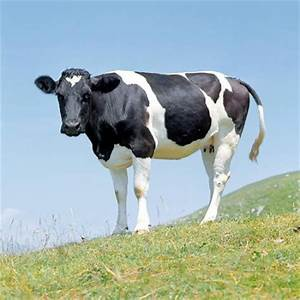

In [ ]:
last_image_path = dir_path + f"images/{cow_df.iloc[image_index]['file_name']}"
last_image = Image.open(last_image_path)
np.asarray(last_image)

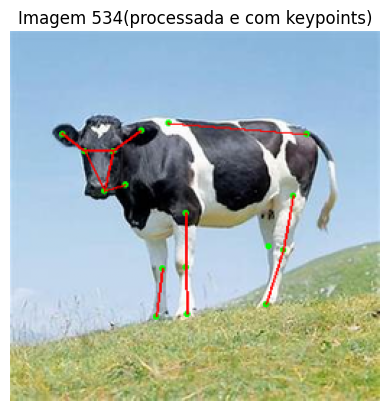

In [101]:
last_image_keypoints = cow_annotations[cow_annotations['image_id'] == cow_df.iloc[image_index]['id']]['keypoints'].values[0]
cow_skeleton = next(img['skeleton'] for img in data['categories'] if img['name'] == 'cow')

normalized_image_test = process_image(last_image_path, last_image_keypoints, cow_skeleton, (256, 256))
plt.title("Imagem 534(processada e com keypoints)")
plt.imshow(normalized_image_test)
plt.axis('off')
plt.show()

Assim pode-se concluir o processamento das imagens, visto que elas são normalizadas, redimensionadas e atreladas à seus devidos keypoints